In [142]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import scipy

In [2]:
def scipy_wavelength(data):
    xval = np.zeros(size, dtype=float, order='C')
    for i in range(0,size):
        xval[i] = i

In [3]:
def wave_length(data, zero_index, min_guess, max_guess): 
    #data should be an array of amplitudes? maybe at the main frequency?
    size = data.shape[0]
    xval = np.zeros(size, dtype=float, order='C')

    for i in range(0,size):
        xval[i] = i-zero_index
    
    #scale down data slowly
    scale = np.zeros(size, dtype=float, order='C')
    xval = np.zeros(size, dtype=float, order='C')
    for i in range(0,size):
        xval[i] = i-zero_index

        #creating a piecewise linear scaler that weights the frequencies near the maximum more
        if np.absolute(i-zero_index)<2*max_guess:
            scale[i] = 1
        elif np.absolute(i-zero_index)>6*max_guess:
            scale[i] = 0
        else:
            scale[i] = 1.5-np.absolute(i-zero_index)/(4*max_guess)
    scaled_data = np.multiply(data,scale)
    norm = np.sqrt(np.dot(scaled_data,scaled_data))
    
    #find best fitting wave
    best_fit = 0
    wavelength = 0
    wave_fit = 0
    #if someone wants you could try and replace this with a binary search for speed
    for i in range(min_guess,max_guess+1):
        #create cos values
        cosval = np.cos((2*math.pi/i)*(xval))
        coef = np.multiply(data,cosval)
        #integrate data values
        wave_fit = np.dot(coef,data)/np.dot(coef,cosval)
        if wave_fit> best_fit:
            best_fit = wave_fit
            wavelength = i
    return wavelength, best_fit/norm

In [4]:
def wave_guess(D):
    max_value = np.max(D)
    min_value = np.min(D)
    zero_index = np.unravel_index(np.argmax(D), D.shape)[0]
    print (zero_index)
    threshold_end = (max_value - min_value) * .3 + min_value # set the amplitude threshold that marks the end of a syllable
    threshold_start = (max_value - min_value) * .7 + min_value# sets the amplitude threshold that marks the start of the next syllable    

    i=1
    bool1 = True
    while bool1:
        if zero_index+i>len(D)-2:
            print ('never reached end threshold')
            return None
        elif D[zero_index + i] <threshold_end:
            bool1 = False
        i = i+1
    
    bool1 = True
    while bool1: 
        if zero_index+i>len(D)-2:
            print ('never reached end threshold')
            return None
        elif D[zero_index + i] >threshold_start:
            bool1 = False
        i = i+1
    lower = i
    
    bool1 = True
    while bool1:
        if zero_index+i>len(D)-2:
            print ('never reached end threshold')
            return None
        elif D[zero_index + i] <threshold_end:
            bool1 = False
        i = i+1
    upper = i
    
    return zero_index, lower, upper

Testing the wavelength function:

40
max:  40 period guess: (  19 ,  22 )
(18, 0.16473551153218255)


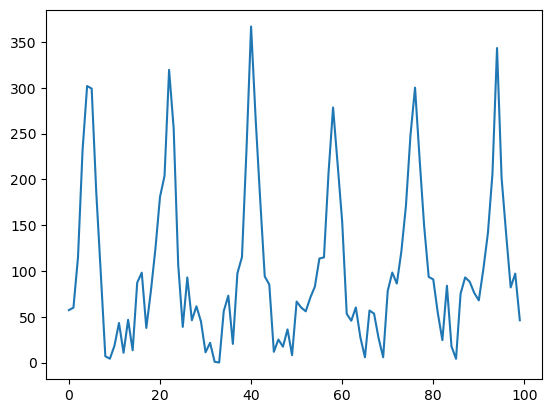

In [5]:
wave = np.zeros(100, dtype=float, order='C')
for i in range(0,100):
    wave[i] = i-40
wave = np.cos((2*math.pi/18)*(wave))
wave = np.square(np.square(np.square((wave+1))))
rando = np.random.rand(100)
wave = wave + 100*rando
wave[40] = wave[40]+30
plt.plot(wave)
zero_index, min_guess, max_guess = wave_guess(wave)
print ('max: ',zero_index, 'period guess: ( ', min_guess, ', ', max_guess, ')')
print (wave_length(wave,zero_index,min_guess-2,max_guess))

In [6]:
def fft_wavelength(data):
    data2 = data- data.mean()
    fft = scipy.fft.fft(data2)
    out = np.absolute(fft)
    return out

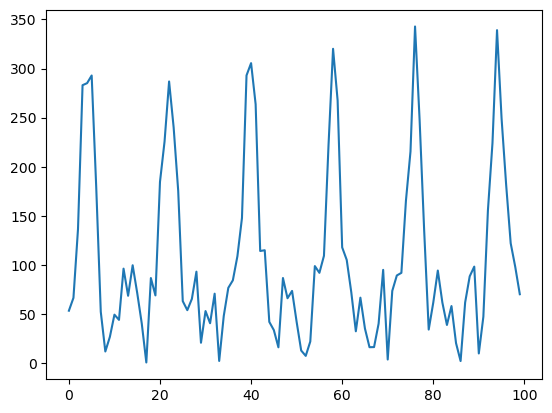

478.93299553586485 1385.9263814172457 705.879055609328


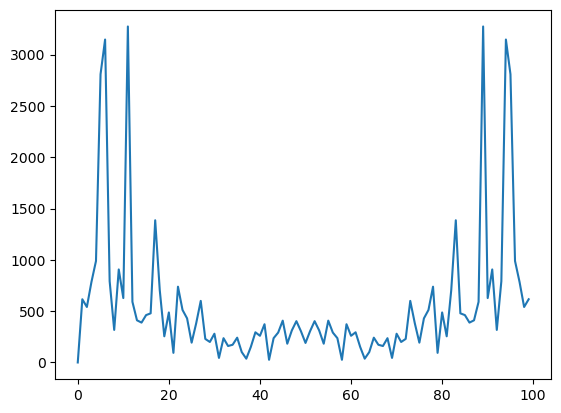

In [7]:
wave = np.zeros(100, dtype=float, order='C')
for i in range(0,100):
    wave[i] = i-40
wave = np.cos((2*math.pi/18)*(wave))
wave = np.square(np.square(np.square((wave+1))))
rando = np.random.rand(100)
wave = wave + 100*rando
wave[40] = wave[40]+30
plt.plot(wave)
plt.show()
fft = fft_wavelength(wave)
plt.plot(fft)
print (fft[16], fft[17], fft[18])

In [143]:
def fft_file(f):
    D = remove_low(f)
    data = D.sum(axis=0)
    data2 = data- data.mean()
    fft = scipy.fft.fft(data2)
    out2 = np.absolute(fft)
    return out2

def remove_low(f):
    song, sr = librosa.load(f)
    D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
    #FIND OUT HOW MANY FREQUENCIES WE REMOVED HERE!
    D=D[64:]
    return D

def filter_non_digits(string):
    result = ''
    for char in string:
        if char in '1234567890':
            result += char
    return result 

def get_fft_top_4(directory):
    df = pd.read_csv('MLNS_Insects_fams_05212024.csv')

    columns = ['fam_or_subfam', 'highest_fft', 'second_highest_fft','third_highest_fft', 'fourth_highest_fft']
    
    out = pd.DataFrame(columns = columns)
    j = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        j=j+1
        if j%100 == 0:
            print (100*j/len(os.listdir(directory)),' percent done')
        if os.path.isfile(f):
            #recover type
            file_name = float(filter_non_digits(f))
            critter_name = df.loc[df.cat_num==file_name].fam_or_subfam
            
            #recover fft
            fft = fft_file(f)
            time = fft.shape[0]
            halftime = int(time/2)
            fft1 = 0
            freq1 = 0
            fft2 = 0 
            freq2 = 0
            fft3 = 0
            freq3 = 0
            fft4 = 0
            freq4 = 0
            for i in range(1,halftime):
                if i/(2*time)*(60)*(40)>20:
                    value = fft[i]
                    if value>fft1:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = fft2
                        freq3 = freq2
                        fft2 = fft1
                        freq2 = freq1
                        fft1 = value
                        freq1 = i/(2*time)*(60)*(40)
                    elif value>fft2:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = fft2
                        freq3 = freq2
                        fft2 = value
                        freq2 = i/(2*time)*(60)*(40)
                    elif value>fft3:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = value
                        freq3 = i/(2*time)*(60)*(40)
                    elif value>fft4:
                        fft4 = value
                        freq4 = i/(2*time)*(60)*(40)
            new_dict = {'fam_or_subfam': critter_name, 'highest_fft':freq1, 'second_highest_fft':freq2,'third_highest_fft':freq3, 'fourth_highest_fft':freq4}
            new_row = pd.DataFrame(new_dict)
            out = pd.concat([out, new_row])
    print ('100% done')
    return out

In [135]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'
hop_length = 1024
n_fft = 2048

data = get_fft_top_4(directory)

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/965927658.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1.6337199803953601  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


3.2674399607907203  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(


4.901159941186081  percent done
6.534879921581441  percent done
8.168599901976801  percent done
9.802319882372162  percent done
11.436039862767522  percent done
13.069759843162881  percent done
14.703479823558242  percent done
16.337199803953602  percent done
17.97091978434896  percent done
19.604639764744324  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


21.238359745139682  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(


22.872079725535045  percent done
24.505799705930404  percent done
26.139519686325762  percent done
27.773239666721125  percent done
29.406959647116484  percent done
31.040679627511846  percent done
32.674399607907205  percent done
34.30811958830257  percent done
35.94183956869792  percent done
37.575559549093285  percent done
39.20927952948865  percent done
40.842999509884  percent done
42.476719490279365  percent done
44.11043947067473  percent done
45.74415945107009  percent done
47.377879431465445  percent done
49.01159941186081  percent done
50.64531939225617  percent done
52.279039372651525  percent done
53.91275935304689  percent done
55.54647933344225  percent done
57.180199313837605  percent done
58.81391929423297  percent done
60.44763927462833  percent done
62.08135925502369  percent done
63.71507923541905  percent done
65.34879921581441  percent done
66.98251919620976  percent done
68.61623917660513  percent done
70.24995915700049  percent done
71.88367913739584  percent don

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1293
  warnings.warn(


78.4185590589773  percent done
80.05227903937265  percent done
81.685999019768  percent done
83.31971900016337  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(


84.95343898055873  percent done
86.5871589609541  percent done
88.22087894134945  percent done
89.85459892174481  percent done
91.48831890214018  percent done
93.12203888253553  percent done
94.75575886293089  percent done
96.38947884332626  percent done
98.02319882372161  percent done
99.65691880411697  percent done
100% done


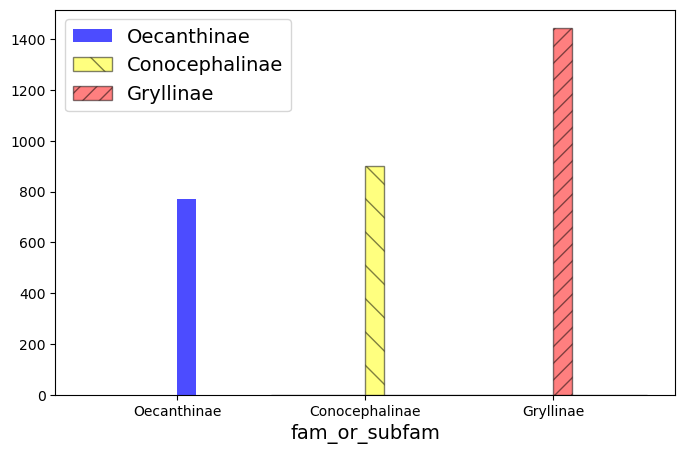

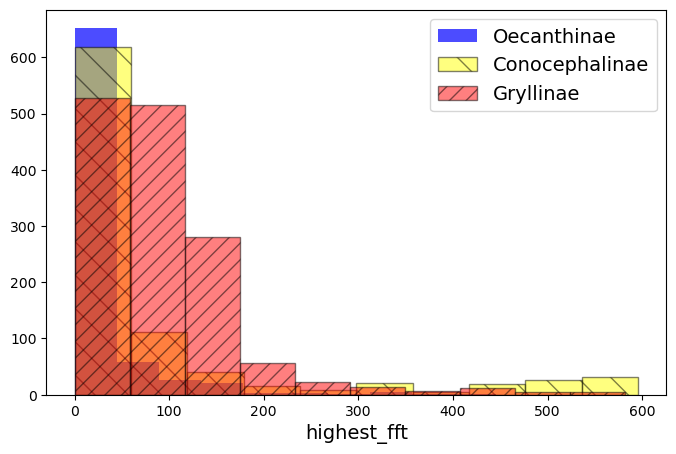

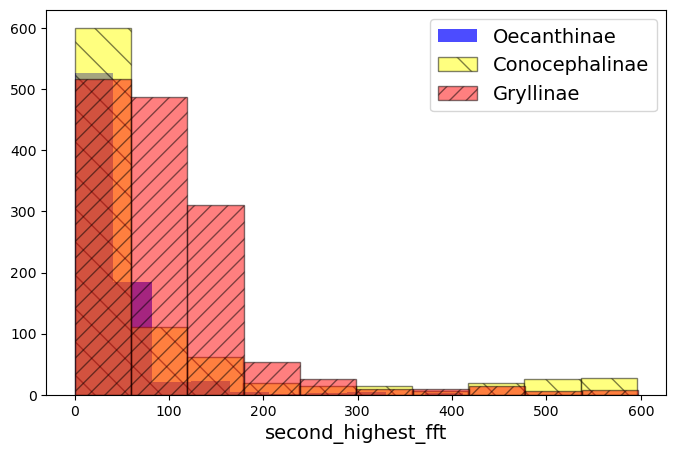

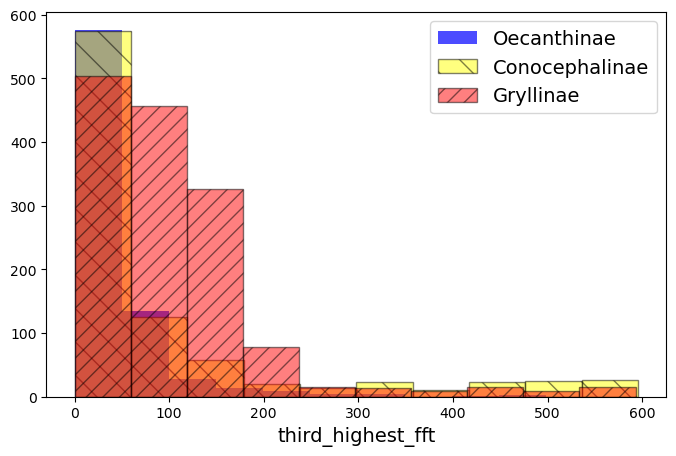

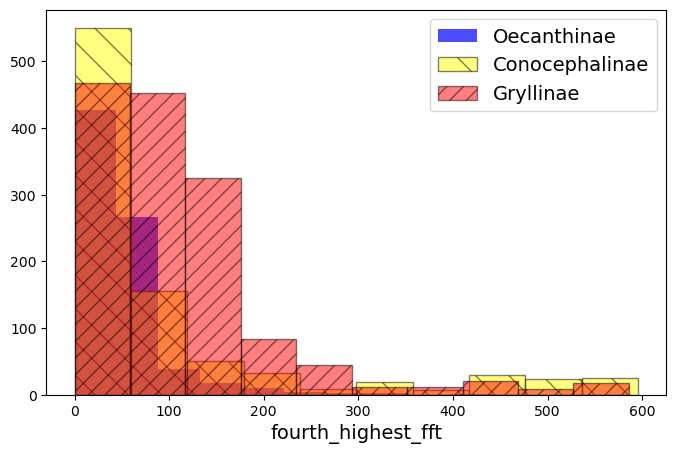

In [116]:
for col in data.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data.loc[data.fam_or_subfam=='Oecanthinae', col].values,
                color='blue',
                alpha=.7,
                label="Oecanthinae")

    plt.hist(data.loc[data.fam_or_subfam=='Conocephalinae', col].values,
                color='yellow',
                alpha=.5,
                hatch = '\\',
                edgecolor='black',
                label="Conocephalinae")

    plt.hist(data.loc[data.fam_or_subfam=='Gryllinae', col].values,
            color='red',
            alpha=.5,
            hatch = '//',
            edgecolor='black',
            label="Gryllinae")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

In [106]:
data.head(50)

fam_or_subfam  highest_fft  second_highest_fft  third_highest_fft  \
126        Oecanthinae    25.058005           44.547564          33.410673   
1755    Conocephalinae   114.153132          108.584687         116.937355   
1833    Conocephalinae    50.116009           27.842227          30.626450   
7299         Gryllinae    22.273782           25.058005          27.842227   
12569        Gryllinae   130.693069          154.455446         122.772277   
2591       Oecanthinae    21.818182           32.727273          54.545455   
5657       Oecanthinae    38.979118           55.684455          44.547564   
1847    Conocephalinae    27.842227           30.626450          33.410673   
1761    Conocephalinae   573.549884           36.194896          27.842227   
138     Conocephalinae    33.410673           38.979118          50.116009   
8125       Oecanthinae    22.273782           25.058005          33.410673   
1789    Conocephalinae   141.995360          139.211137         136.426914   
9843         Gryllinae   172.621810          270.069606         236.658933   
7919         Cicadidae    30.626450           22.273782          66.821346   
2144        Nemobiinae    30.626450           27.842227          33.410673   
1189        Hapithinae     0.000000            0.000000           0.000000   
8137       Oecanthinae    27.842227           22.273782          58.468677   
179      Tettigoniinae    64.037123           47.331787          22.273782   
891      Mogoplistinae   277.685950          267.768595         287.603306   
6105         Gryllinae    61.252900           52.900232         125.290023   
10138        Gryllinae    97.447796          114.153132         133.642691   
3058   Phaneropterinae   493.779904          522.488038         488.038278   
184      Tettigoniinae     0.000000            0.000000           0.000000   
897      Mogoplistinae   150.348028          300.696056         451.044084   
7070        Hapithinae    91.879350           25.058005          33.410673   
8556         Cicadidae   118.032787          124.590164         131.147541   
280        Oecanthinae   133.333333          400.000000         266.666667   
1200        Hapithinae     0.000000            0.000000           0.000000   
6565         Gryllinae    25.065274           21.932115          31.331593   
2150        Nemobiinae    27.972028           83.916084          55.944056   
2177        Nemobiinae   451.094891          455.474453         459.854015   
6407    Conocephalinae    64.037123          130.858469          33.410673   
8960         Gryllinae   130.858469          116.937355         141.995360   
6892        Nemobiinae    33.410673           27.842227          41.763341   
7728         Gryllinae   108.584687          111.368910         105.800464   
5271        Nemobiinae    67.549669           59.602649          79.470199   
2790     Trigonidiinae    27.842227           33.410673         548.491879   
3322     Trigonidiinae    47.129909           94.259819          97.885196   
5285        Nemobiinae   105.439331          115.481172         100.418410   
6092         Gryllinae     0.000000            0.000000           0.000000   
3336     Trigonidiinae    41.763341           47.331787          80.742459   
7100         Gryllinae    38.979118           27.842227          55.684455   
13232   Conocephalinae    26.086957           52.173913          78.260870   
5026     Trigonidiinae    20.547945           36.986301          28.767123   
11390        Gryllinae   180.974478          178.190255         183.758701   
287        Oecanthinae    27.842227           72.389791          47.331787   
3573     Trigonidiinae   256.891496          260.410557         267.448680   
1804    Conocephalinae     0.000000            0.000000           0.000000   
11418        Gryllinae   136.426914          133.642691         139.211137   
6414     Trigonidiinae    55.684455           64.037123          58.468677   

       fourth_highest_fft  
12

(20.0, 200.0)

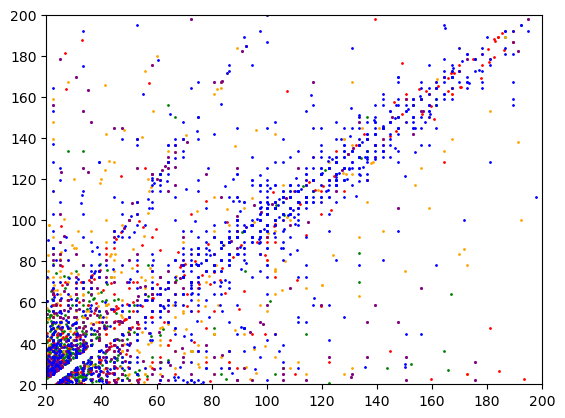

In [118]:
plt.scatter(data.loc[data.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Conocephalinae', 'second_highest_fft'].values,
            c = "purple",
            s = 1,
            label='Conocephalinae')
plt.scatter(data.loc[data.fam_or_subfam=='Oecanthinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Oecanthinae', 'second_highest_fft'].values,
            c = "green",
            s = 1,
            label='Oecanthinae')
plt.scatter(data.loc[data.fam_or_subfam=='Phaneropterinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Phaneropterinae', 'second_highest_fft'].values,
            c = "orange",
            s = 1,
            label='Phaneropterinae')
plt.scatter(data.loc[data.fam_or_subfam=='Trigonidiinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Trigonidiinae', 'second_highest_fft'].values,
            c = "red",
            s = 1,
            label='Trigonidiinae')
plt.scatter(data.loc[data.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Conocephalinae', 'second_highest_fft'].values,
            c = "purple",
            s = 1,
            label='Conocephalinae')
plt.scatter(data.loc[data.fam_or_subfam=='Gryllinae', 'highest_fft'].values,
           data.loc[data.fam_or_subfam=='Gryllinae', 'second_highest_fft'].values,
            c = "blue",
            s = 1,
            label='Gryllinae')
plt.xlim(20,200)
plt.ylim(20,200)

In [138]:
def main_freq_not_scaled(song, cutoff = 800):
    D = np.abs(librosa.stft(song))
    cut = int(float(cutoff)/(librosa.fft_frequencies()[1]))
    D = D[cut:]
    DB = librosa.amplitude_to_db(D, ref=np.max)
    maxmean = np.mean(DB[0,:])
    main_meanfreq = 0
    maxvar = np.var(DB[0,:])
    main_varfreq = 0
    for x in range(1,DB.shape[0]):
        mean = np.mean(DB[x,:])
        var = np.var(DB[x,:])
        if mean > maxmean:
            maxmean = mean
            main_meanfreq = x
        if var > maxvar:
            maxvar = var
            main_varfreq = x
    return main_varfreq, main_meanfreq

def fft_file_at_main_freq(f, cutoff = 800):
    song, sr = librosa.load(f)

    D = np.abs(librosa.stft(song))
    cut = int(float(cutoff)/(librosa.fft_frequencies()[1]))
    D = D[cut:]
    DB = librosa.amplitude_to_db(D, ref=np.max)

    maxvar = np.var(DB[0,:])
    main_varfreq = 0
    for x in range(1,DB.shape[0]):
        mean = np.mean(DB[x,:])
        var = np.var(DB[x,:])

        if var > maxvar:
            maxvar = var
            main_varfreq = x

    data = D[main_varfreq,:]
    data2 = data- data.mean()
    fft = scipy.fft.fft(data2)
    out2 = np.absolute(fft)
    return out2

def get_fft_top_4_at_main_freq(directory):
    df = pd.read_csv('MLNS_Insects_fams_05212024.csv')

    columns = ['fam_or_subfam', 'highest_fft', 'second_highest_fft','third_highest_fft', 'fourth_highest_fft']
    
    out = pd.DataFrame(columns = columns)
    j = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        j=j+1
        if j%100 == 0:
            print (100*j/len(os.listdir(directory)),' percent done')
        if os.path.isfile(f):
            #recover type
            file_name = float(filter_non_digits(f))
            critter_name = df.loc[df.cat_num==file_name].fam_or_subfam
            
            #recover fft
            fft = fft_file_at_main_freq(f)
            time = fft.shape[0]
            halftime = int(time/2)-1
            fft1 = 0
            freq1 = 0
            fft2 = 0 
            freq2 = 0
            fft3 = 0
            freq3 = 0
            fft4 = 0
            freq4 = 0
            for i in range(1,halftime):
                if i/(2*time)*(60)*(40)>20:
                    value = fft[i]
                    if value>fft1:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = fft2
                        freq3 = freq2
                        fft2 = fft1
                        freq2 = freq1
                        fft1 = value
                        freq1 = i/(2*time)*(60)*(40)
                    elif value>fft2:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = fft2
                        freq3 = freq2
                        fft2 = value
                        freq2 = i/(2*time)*(60)*(40)
                    elif value>fft3:
                        fft4 = fft3
                        freq4 = freq3
                        fft3 = value
                        freq3 = i/(2*time)*(60)*(40)
                    elif value>fft4:
                        fft4 = value
                        freq4 = i/(2*time)*(60)*(40)
            new_dict = {'fam_or_subfam': critter_name, 'highest_fft':freq1, 'second_highest_fft':freq2,'third_highest_fft':freq3, 'fourth_highest_fft':freq4}
            new_row = pd.DataFrame(new_dict)
            out = pd.concat([out, new_row])
    print ('100% done')
    return out

In [139]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'
hop_length = 1024
n_fft = 2048

data_at_main_freq = get_fft_top_4_at_main_freq(directory)

/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/3808306572.py:104: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out = pd.concat([out, new_row])
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(


1.6337199803953601  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1250
  warnings.warn(
/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(


3.2674399607907203  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(


4.901159941186081  percent done
6.534879921581441  percent done
8.168599901976801  percent done
9.802319882372162  percent done
11.436039862767522  percent done
13.069759843162881  percent done
14.703479823558242  percent done
16.337199803953602  percent done
17.97091978434896  percent done
19.604639764744324  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(


21.238359745139682  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1814
  warnings.warn(


22.872079725535045  percent done
24.505799705930404  percent done
26.139519686325762  percent done
27.773239666721125  percent done
29.406959647116484  percent done
31.040679627511846  percent done
32.674399607907205  percent done
34.30811958830257  percent done
35.94183956869792  percent done
37.575559549093285  percent done
39.20927952948865  percent done
40.842999509884  percent done
42.476719490279365  percent done
44.11043947067473  percent done
45.74415945107009  percent done
47.377879431465445  percent done
49.01159941186081  percent done
50.64531939225617  percent done
52.279039372651525  percent done
53.91275935304689  percent done
55.54647933344225  percent done
57.180199313837605  percent done
58.81391929423297  percent done
60.44763927462833  percent done
62.08135925502369  percent done
63.71507923541905  percent done
65.34879921581441  percent done
66.98251919620976  percent done
68.61623917660513  percent done
70.24995915700049  percent done
71.88367913739584  percent don

/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1293
  warnings.warn(


78.4185590589773  percent done
80.05227903937265  percent done
81.685999019768  percent done
83.31971900016337  percent done


/opt/anaconda3/envs/erdos_may_2024/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1208
  warnings.warn(


84.95343898055873  percent done
86.5871589609541  percent done
88.22087894134945  percent done
89.85459892174481  percent done
91.48831890214018  percent done
93.12203888253553  percent done
94.75575886293089  percent done
96.38947884332626  percent done
98.02319882372161  percent done
99.65691880411697  percent done
100% done


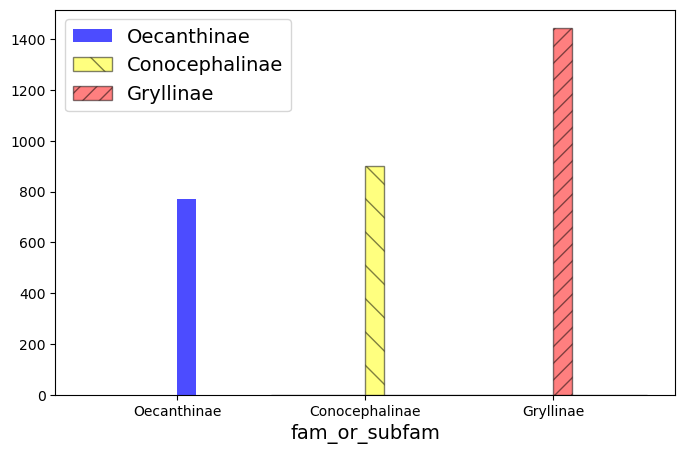

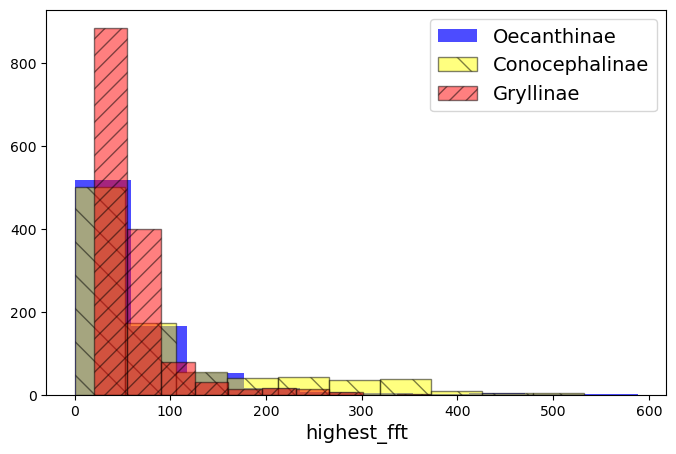

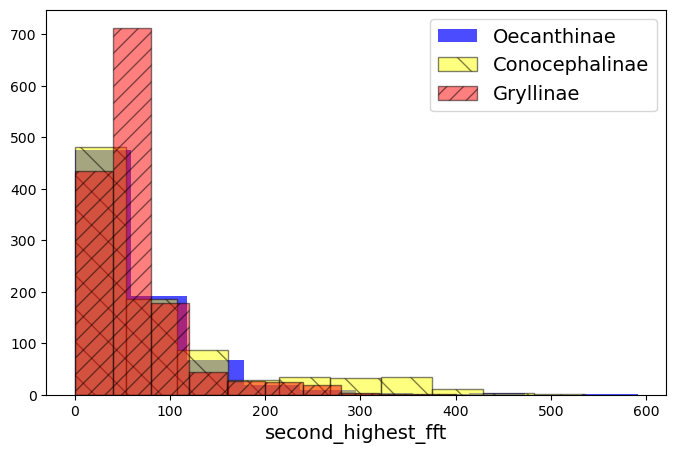

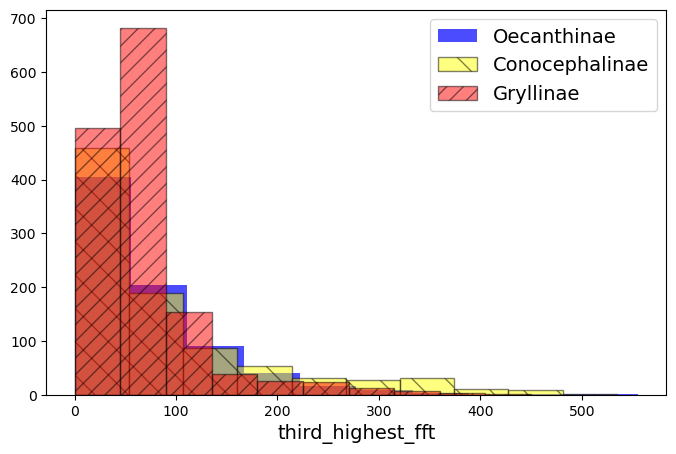

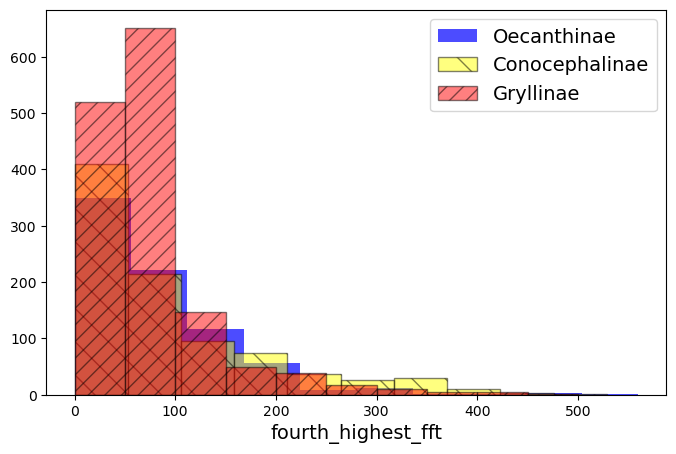

In [115]:
for col in data_at_main_freq.columns:
    plt.figure(figsize=(8,5))


    plt.hist(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Oecanthinae', col].values,
                color='blue',
                alpha=.7,
                label="Oecanthinae")

    plt.hist(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Conocephalinae', col].values,
                color='yellow',
                alpha=.5,
                hatch = '\\',
                edgecolor='black',
                label="Conocephalinae")

    plt.hist(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Gryllinae', col].values,
            color='red',
            alpha=.5,
            hatch = '//',
            edgecolor='black',
            label="Gryllinae")

    plt.xlabel(col, fontsize=14)
    plt.legend(fontsize=14)

    plt.show()

In [121]:
data_at_main_freq.head(50)

fam_or_subfam  highest_fft  second_highest_fft  third_highest_fft  \
126        Oecanthinae    29.234339           23.665893         297.911833   
1755    Conocephalinae    54.292343           57.076566          58.468677   
1833    Conocephalinae   100.232019           26.450116          25.058005   
7299         Gryllinae    47.331787          101.624130          45.939675   
12569        Gryllinae    65.346535           77.227723          67.326733   
2591       Oecanthinae   104.109589          136.986301         169.863014   
5657       Oecanthinae    20.881671           41.763341          45.939675   
1847    Conocephalinae    20.881671           22.273782          34.802784   
1761    Conocephalinae    37.587007           20.881671          36.194896   
138     Conocephalinae    64.037123           54.292343         179.582367   
8125       Oecanthinae    23.665893          128.074246         167.053364   
1789    Conocephalinae    70.997680           69.605568          72.389791   
9843         Gryllinae    91.879350           62.645012          77.958237   
7919         Cicadidae   201.856148          200.464037         199.071926   
2144        Nemobiinae    45.939675           52.900232          30.626450   
1189        Hapithinae   240.000000            0.000000           0.000000   
8137       Oecanthinae    26.450116           29.234339          20.881671   
179      Tettigoniinae    23.665893           36.194896          27.842227   
891      Mogoplistinae   139.130435          134.161491         144.099379   
6105         Gryllinae    30.626450           26.450116          62.645012   
10138        Gryllinae    48.723898           66.821346          57.076566   
3058   Phaneropterinae   246.889952          255.502392         258.373206   
184      Tettigoniinae     0.000000            0.000000           0.000000   
897      Mogoplistinae    75.174014          150.348028         225.522042   
7070        Hapithinae    44.547564           43.155452          45.939675   
8556         Cicadidae    59.178082           62.465753          65.753425   
280        Oecanthinae    66.666667          400.000000         466.666667   
1200        Hapithinae   240.000000            0.000000           0.000000   
6565         Gryllinae    20.392157           31.372549          53.333333   
2150        Nemobiinae    41.958042           37.762238          74.125874   
2177        Nemobiinae   225.959781          451.919561         228.153565   
6407    Conocephalinae    32.018561          164.269142         296.519722   
8960         Gryllinae    65.429234           58.468677          68.213457   
6892        Nemobiinae    57.076566          105.800464          33.410673   
7728         Gryllinae    54.292343           52.900232          55.684455   
5271        Nemobiinae    33.830846           29.850746          23.880597   
2790     Trigonidiinae   148.955916          225.522042         229.698376   
3322     Trigonidiinae    47.201210           49.016641          68.986384   
5285        Nemobiinae    52.830189           57.861635          50.314465   
6092         Gryllinae   240.000000            0.000000           0.000000   
3336     Trigonidiinae    40.371230           20.881671          27.842227   
7100         Gryllinae    27.842227           41.763341          40.371230   
13232   Conocephalinae    26.086957          286.956522         352.173913   
5026     Trigonidiinae   115.068493           69.863014          98.630137   
11390        Gryllinae    90.487239           89.095128          91.879350   
287        Oecanthinae    65.429234           37.587007          70.997680   
3573     Trigonidiinae   470.484581          472.246696         468.722467   
1804    Conocephalinae   240.000000            0.000000           0.000000   
11418        Gryllinae    68.213457           66.821346          69.605568   
6414     Trigonidiinae    29.234339           36.194896          27.842227   

       fourth_highest_fft  
12

(20.0, 200.0)

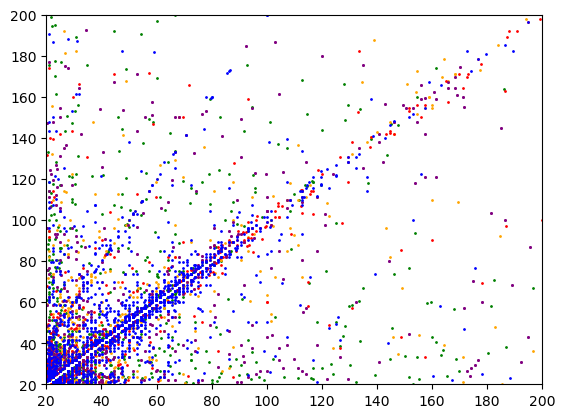

In [117]:
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Conocephalinae', 'second_highest_fft'].values,
            c = "purple",
            s = 1,
            label='Conocephalinae')
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Oecanthinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Oecanthinae', 'second_highest_fft'].values,
            c = "green",
            s = 1,
            label='Oecanthinae')
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Phaneropterinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Phaneropterinae', 'second_highest_fft'].values,
            c = "orange",
            s = 1,
            label='Phaneropterinae')
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Trigonidiinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Trigonidiinae', 'second_highest_fft'].values,
            c = "red",
            s = 1,
            label='Trigonidiinae')
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Conocephalinae', 'second_highest_fft'].values,
            c = "purple",
            s = 1,
            label='Conocephalinae')
plt.scatter(data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Gryllinae', 'highest_fft'].values,
           data_at_main_freq.loc[data_at_main_freq.fam_or_subfam=='Gryllinae', 'second_highest_fft'].values,
            c = "blue",
            s = 1,
            label='Gryllinae')
plt.xlim(20,200)
plt.ylim(20,200)

(20.0, 600.0)

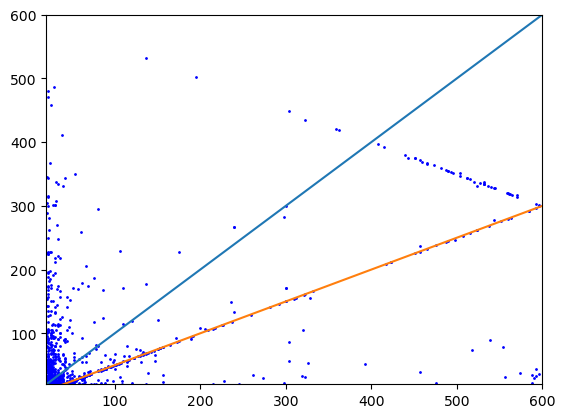

In [140]:
plt.scatter(data.loc[data.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
           data_at_main_freq.loc[data.fam_or_subfam=='Conocephalinae', 'highest_fft'].values,
            c = "blue",
            s = 1,
            label='Conocephalinae')
x = np.linspace(0, 600, 100)
plt.plot(x, x, label='linear') 
x = np.linspace(0, 600, 100)
plt.plot(x, 1/2*x, label='linear') 
plt.xlim(20,600)
plt.ylim(20,600)

In [252]:
from sklearn.preprocessing import StandardScaler

def fft_D(D):
    D = D[64:]
    data = D.sum(axis=0)
    time =  D.shape[1]
    halftime = int(time/2)
    data2 = data- data.mean()
    fft = np.absolute(scipy.fft.fft(data2))
    fft2 = fft[2:halftime]
    print(fft2.shape)
    print(fft.shape)
    scaler = StandardScaler()
    out2 = scaler.fit_transform((fft2.T).reshape(-1,1))
    return out2, time

def filter_non_digits(string):
    result = ''
    for char in string:
        if char in '1234567890':
            result += char
    return result 

def graph_fft(directory):
    df = pd.read_csv('MLNS_Insects_fams_05212024.csv')
    j = 0
    for filename in os.listdir(directory):
        j=j+1
        if j%57 == 0:
            f = os.path.join(directory, filename)
            # checking if it is a file
            if os.path.isfile(f):
                #recover type
                file_name = float(filter_non_digits(f))
                critter_name = df.loc[df.cat_num==file_name].fam_or_subfam
                print ('file name: ', file_name)
                print ('critter :', critter_name)

                #print graph
                song, sr = librosa.load(f)
                D = np.abs(librosa.stft(song, n_fft=n_fft,  hop_length=hop_length))
                DB = librosa.amplitude_to_db(D, ref=np.max)
                librosa.display.specshow(DB, hop_length=hop_length, x_axis='time', y_axis='log');
                plt.ylim(750,10000)
                plt.colorbar(format='%+2.0f dB');
                plt.show()
    
                #recover fft
                data, time = fft_D(D)
                if data.shape[0] >2:
                    ar = buckets(data,time)
                    mini = min(125,data.shape[0])
                    for i in range(0,mini):
                        plt.scatter((i+2)/time*20*60 ,data[i])
                    plt.show()
                    plt.plot(ar)
                    plt.show()
    return out

file name:  121248.0
critter : 3311    Trigonidiinae
Name: fam_or_subfam, dtype: object


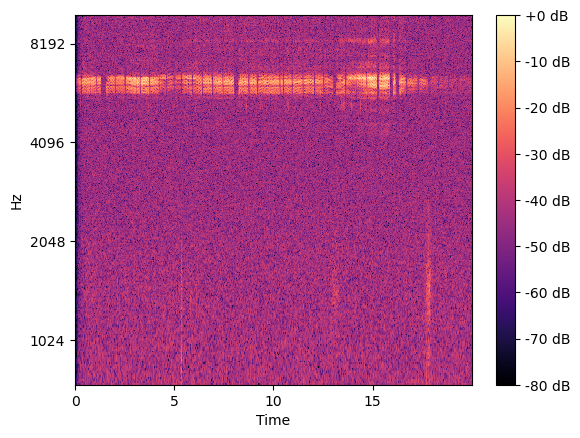

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


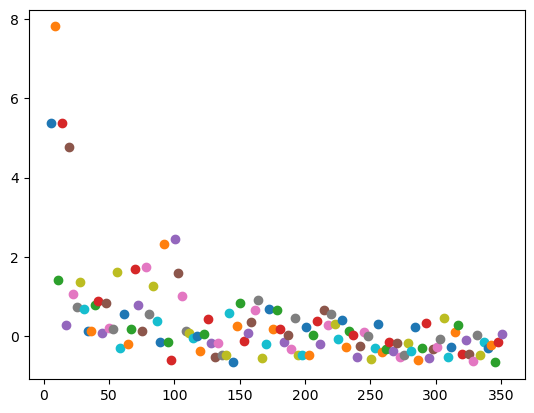

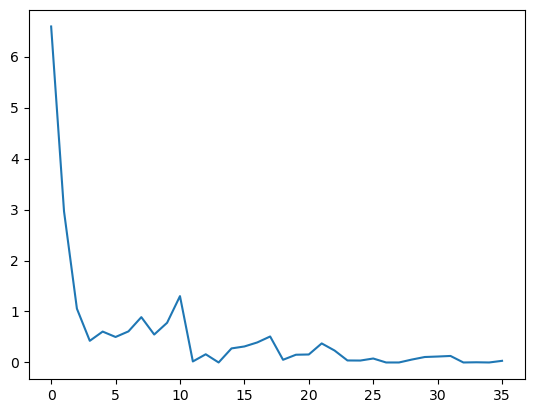

file name:  186424.0
critter : 8523    Oecanthinae
Name: fam_or_subfam, dtype: object


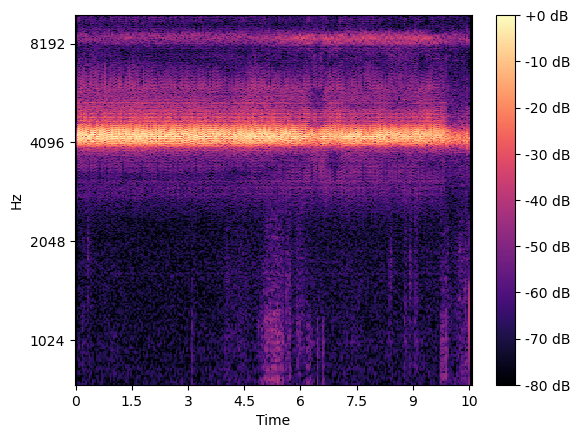

(112,)
(228,)
64


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


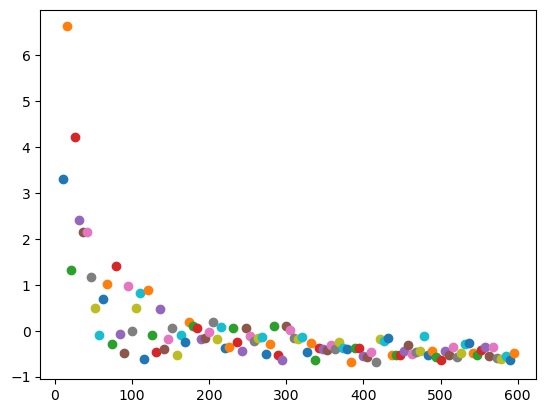

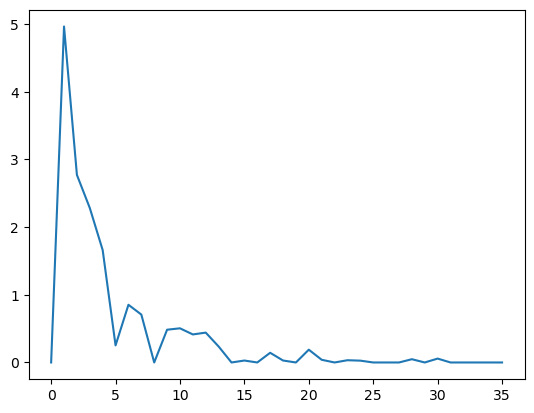

file name:  200362.0
critter : 9106    Gryllinae
Name: fam_or_subfam, dtype: object


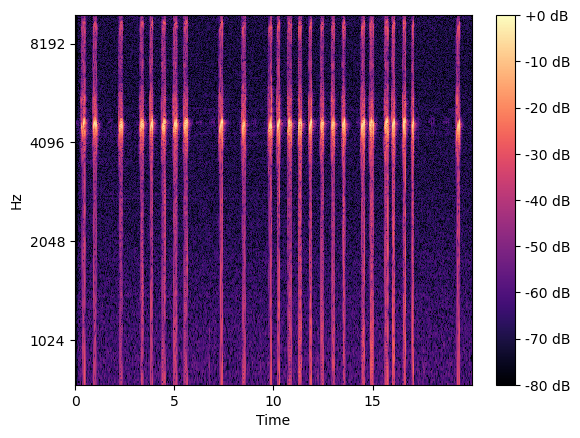

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


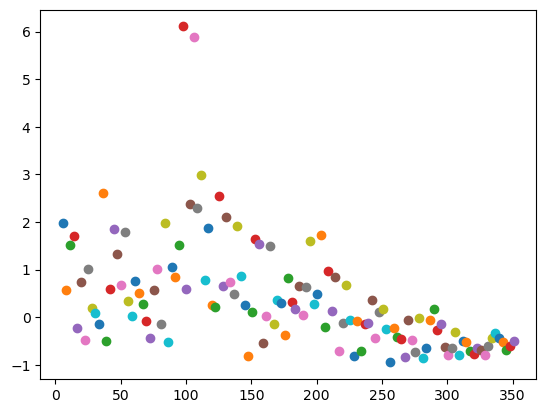

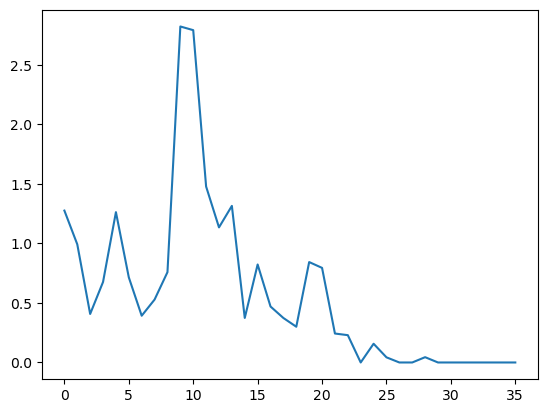

file name:  186141.0
critter : 8242    Oecanthinae
Name: fam_or_subfam, dtype: object


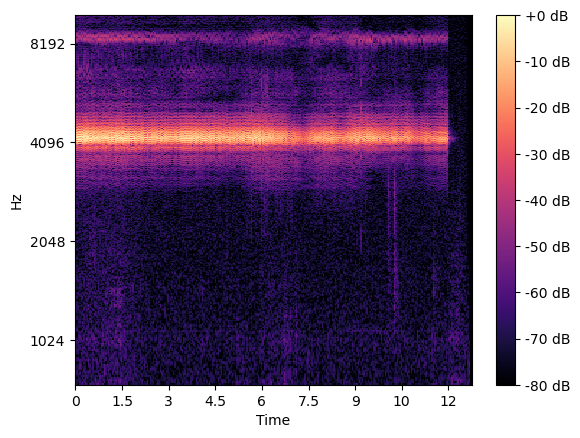

(135,)
(275,)
78


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


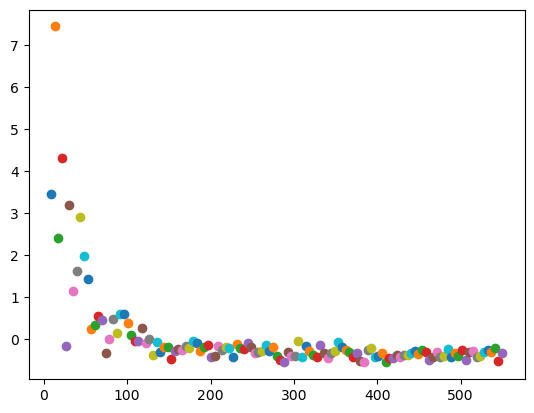

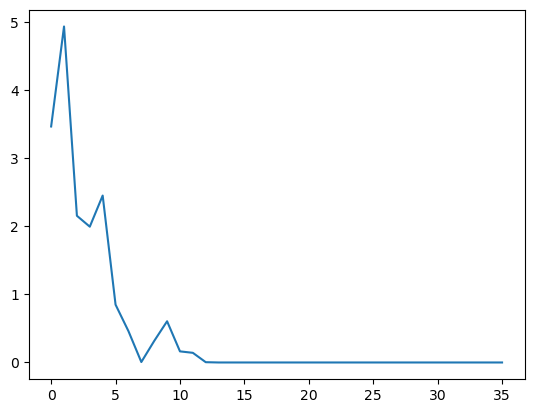

file name:  185892.0
critter : 8012    Oecanthinae
Name: fam_or_subfam, dtype: object


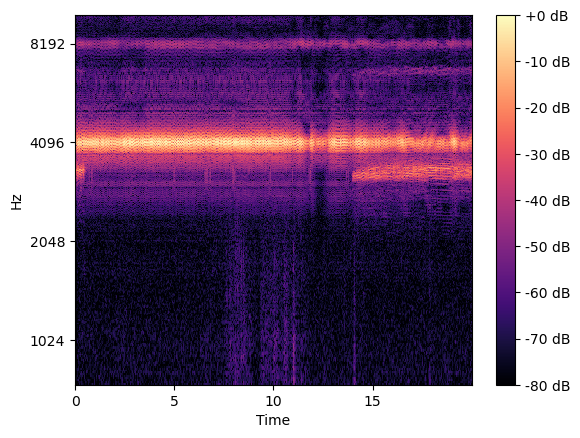

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


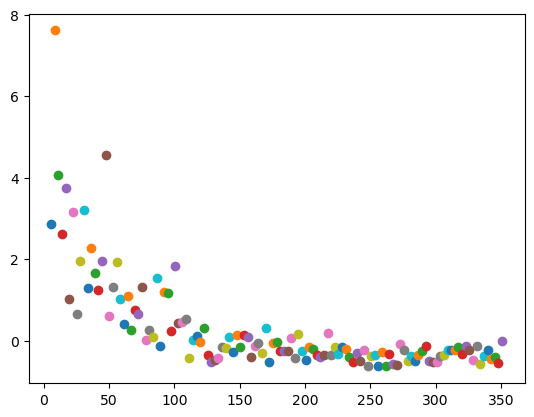

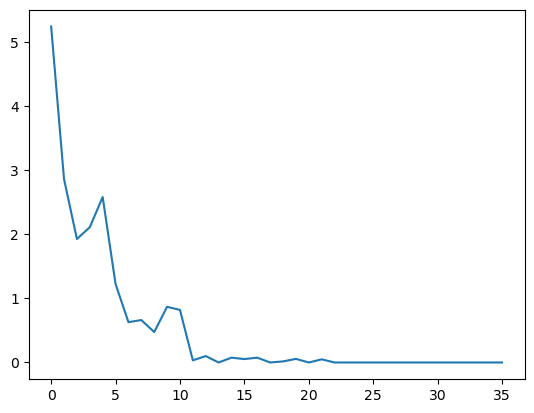

file name:  205192.0
critter : 10393    Gryllinae
Name: fam_or_subfam, dtype: object


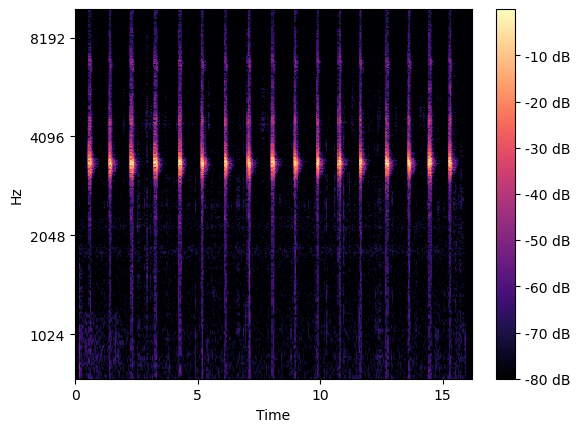

(172,)
(349,)
100


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


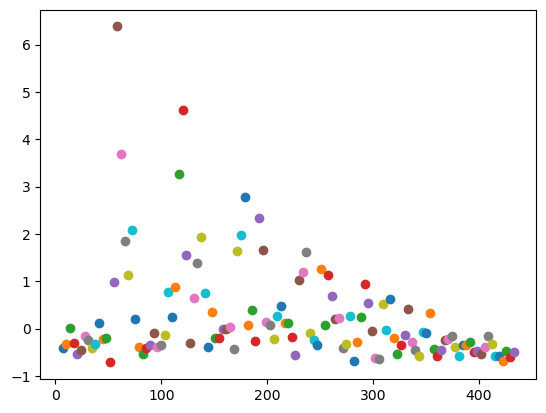

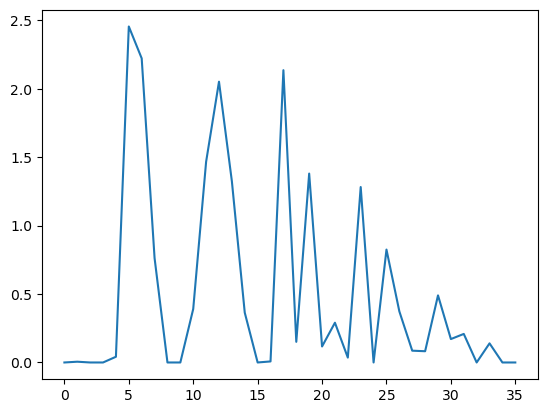

file name:  133868.0
critter : 7081    Gryllinae
Name: fam_or_subfam, dtype: object


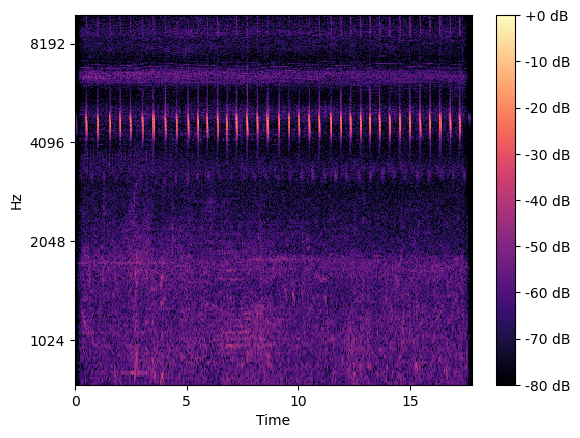

(189,)
(383,)
110


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


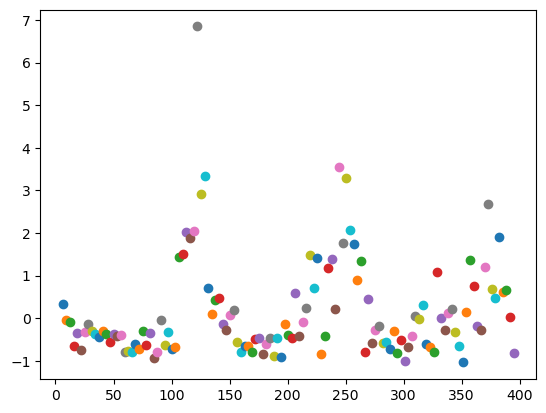

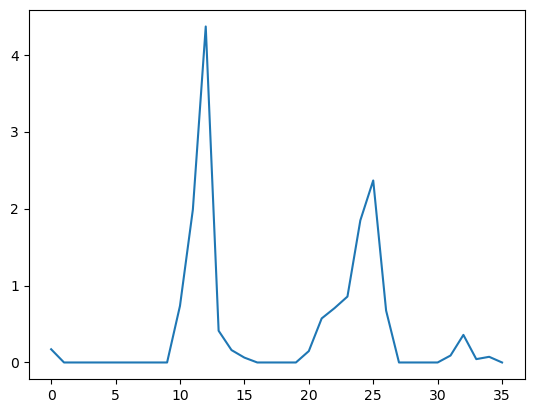

file name:  198037.0
critter : 8601    Gryllinae
Name: fam_or_subfam, dtype: object


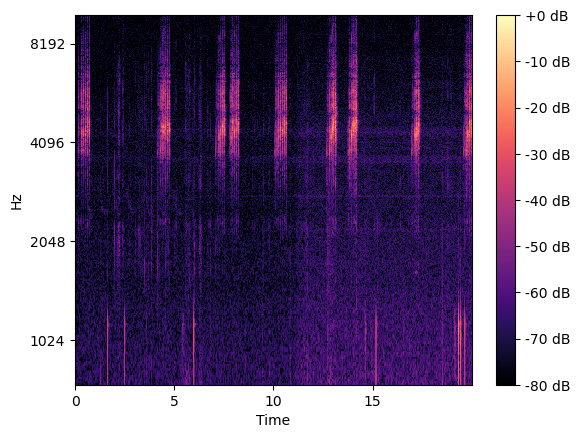

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


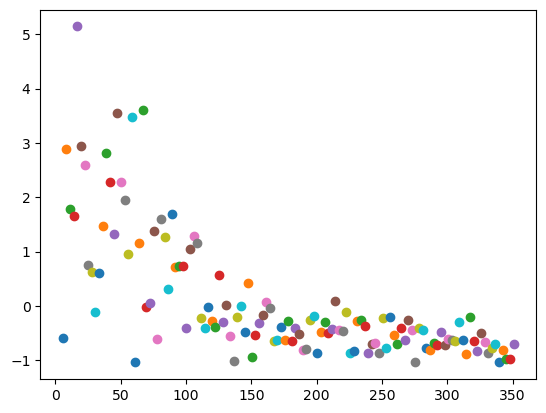

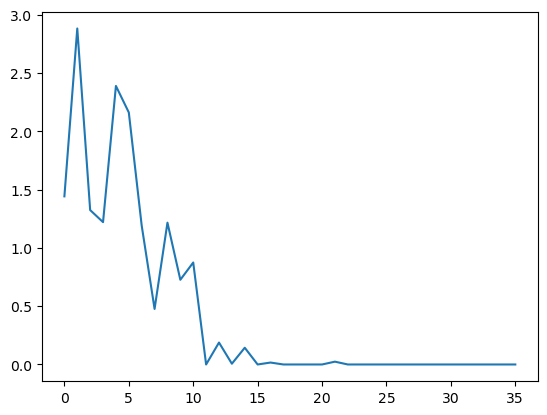

file name:  133505.0
critter : 6738    Trigonidiinae
Name: fam_or_subfam, dtype: object


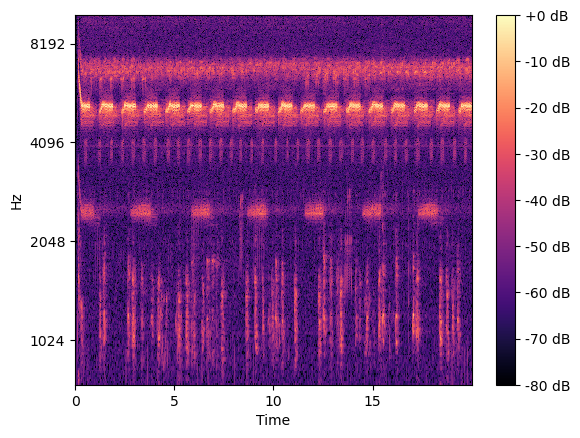

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


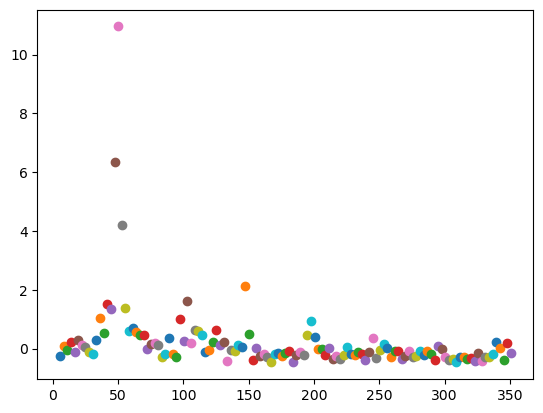

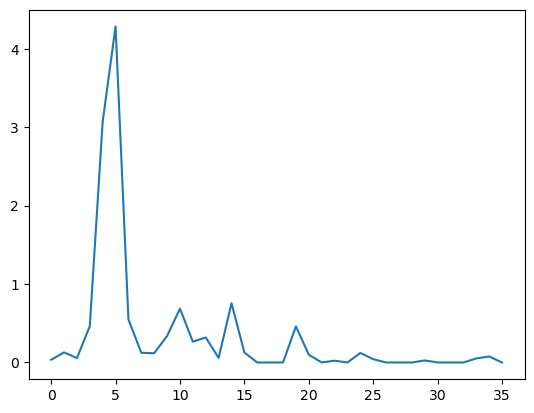

file name:  114435.0
critter : 1100    Hapithinae
Name: fam_or_subfam, dtype: object


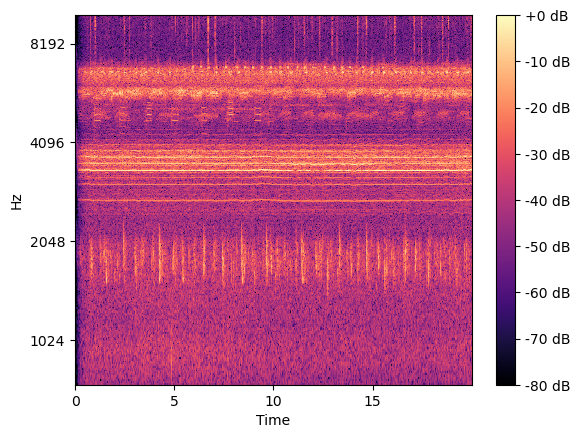

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


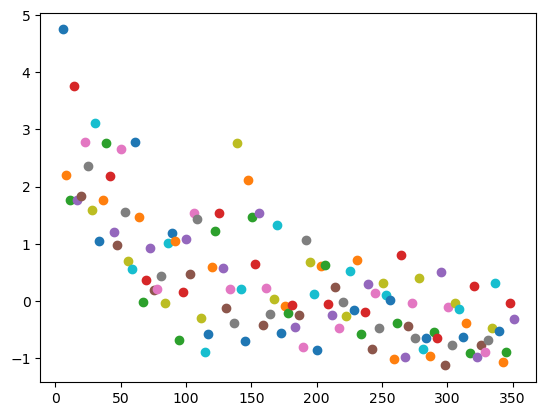

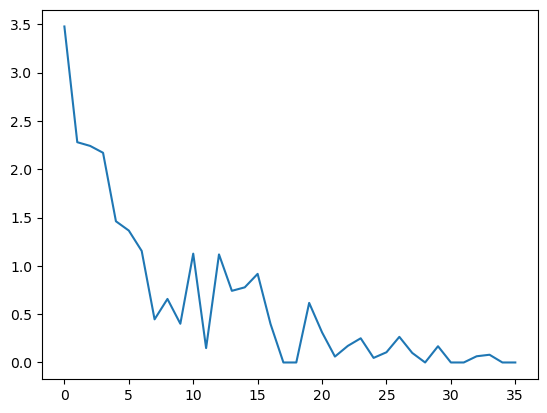

file name:  204112.0
critter : 10017    Gryllinae
Name: fam_or_subfam, dtype: object


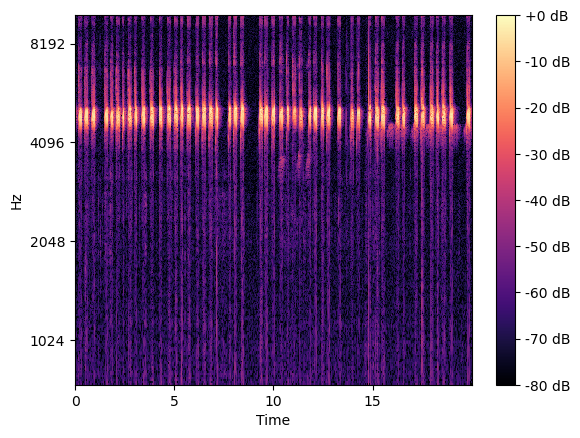

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


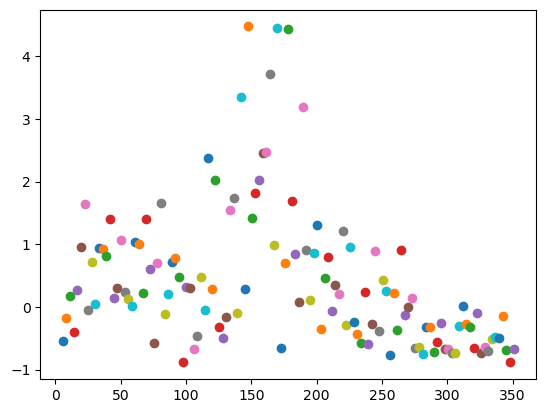

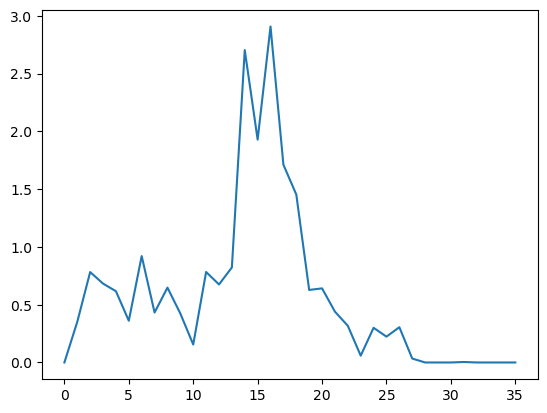

file name:  122409.0
critter : 4129    Conocephalinae
Name: fam_or_subfam, dtype: object


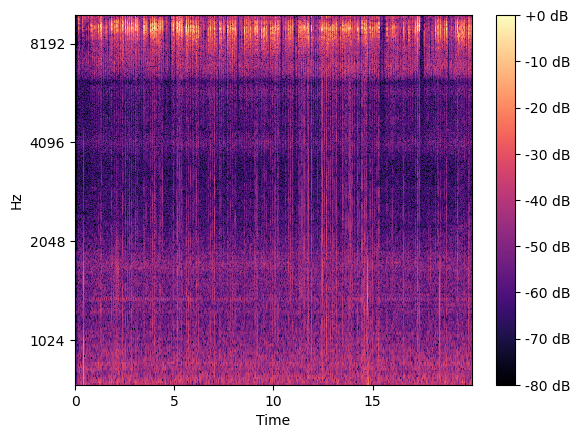

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


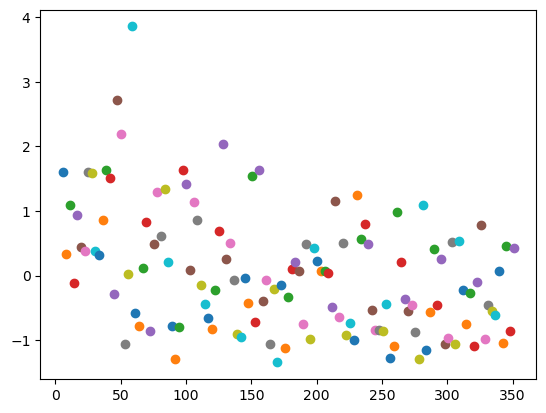

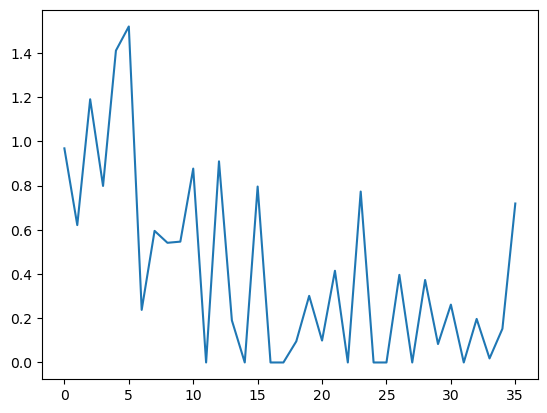

file name:  205191.0
critter : 10392    Gryllinae
Name: fam_or_subfam, dtype: object


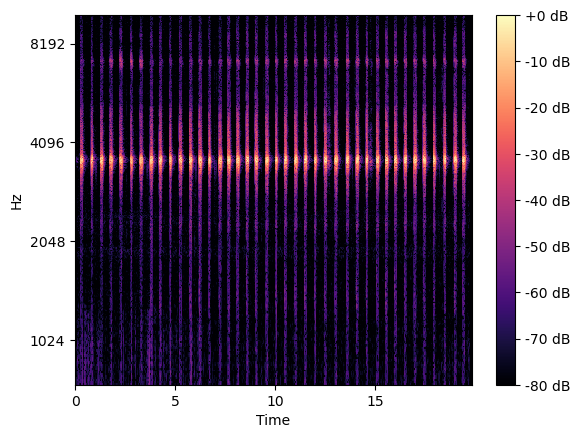

(211,)
(427,)
124


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


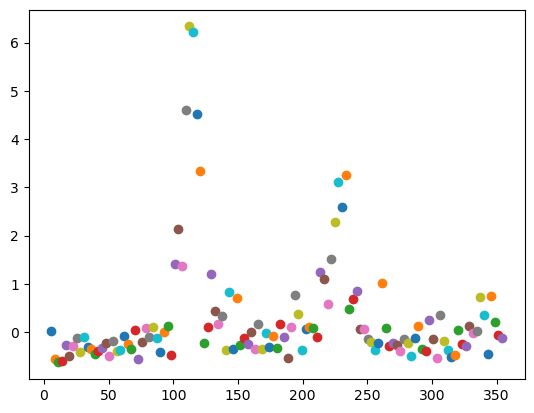

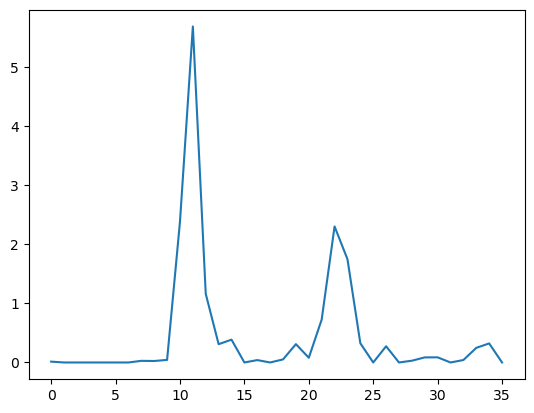

file name:  114232.0
critter : 899    Mogoplistinae
Name: fam_or_subfam, dtype: object


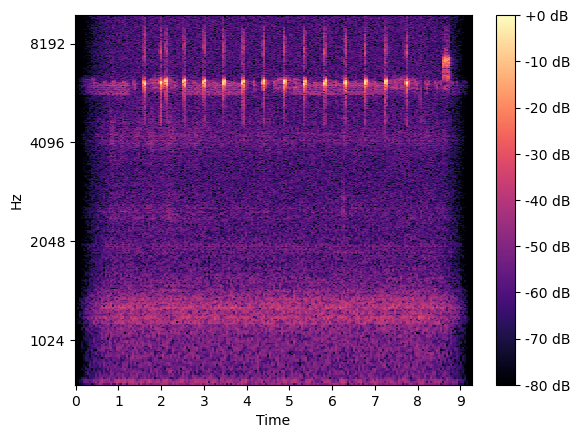

(98,)
(200,)
56


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


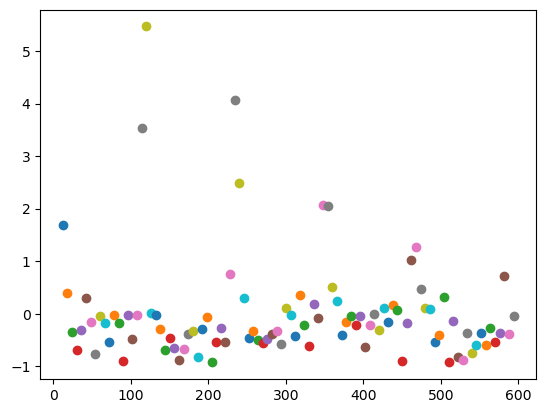

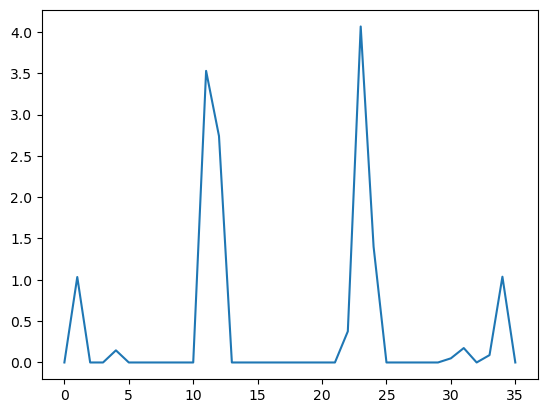

file name:  118395.0
critter : 1806    Conocephalinae
Name: fam_or_subfam, dtype: object


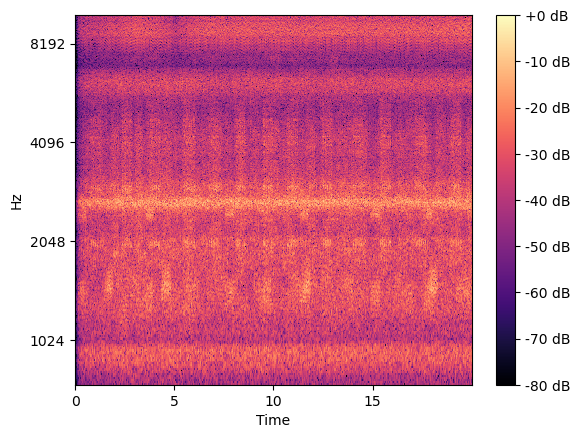

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


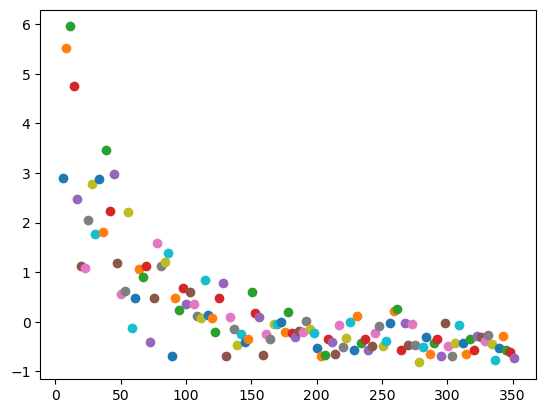

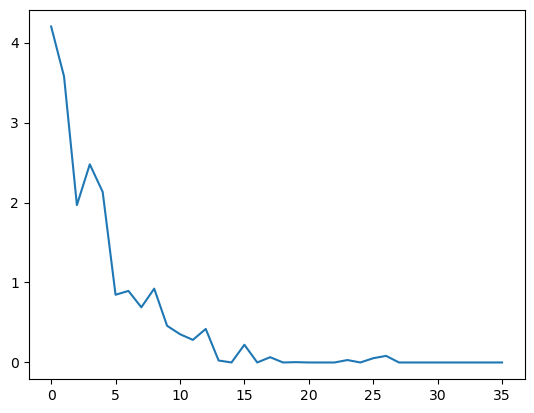

file name:  121851.0
critter : 3773    Phaneropterinae
Name: fam_or_subfam, dtype: object


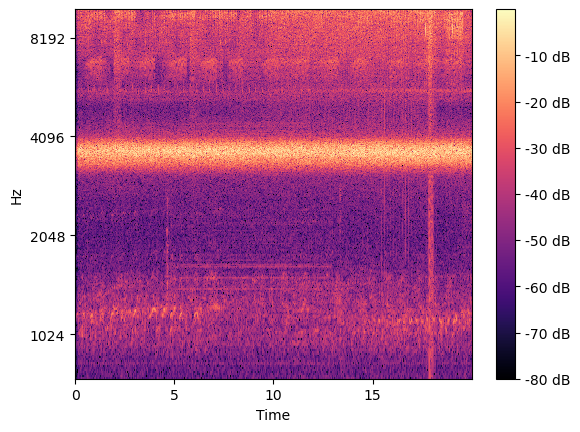

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


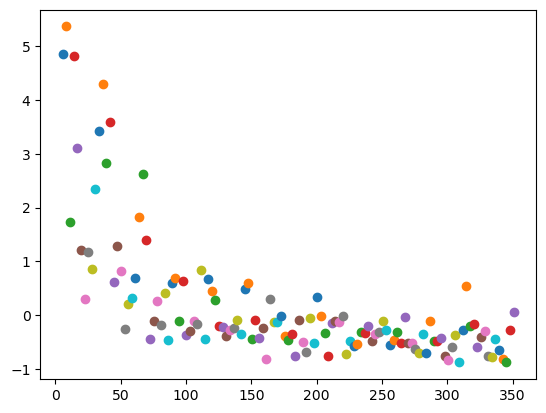

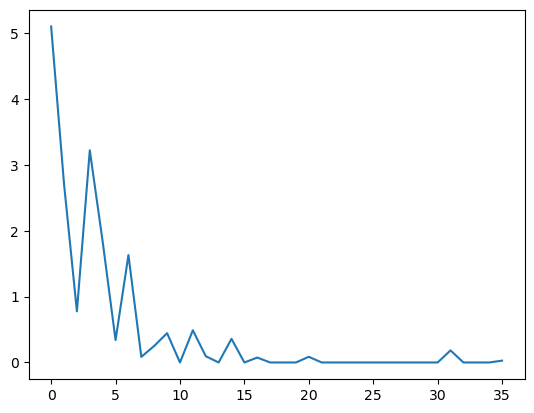

file name:  114418.0
critter : 1083    Trigonidiinae
Name: fam_or_subfam, dtype: object


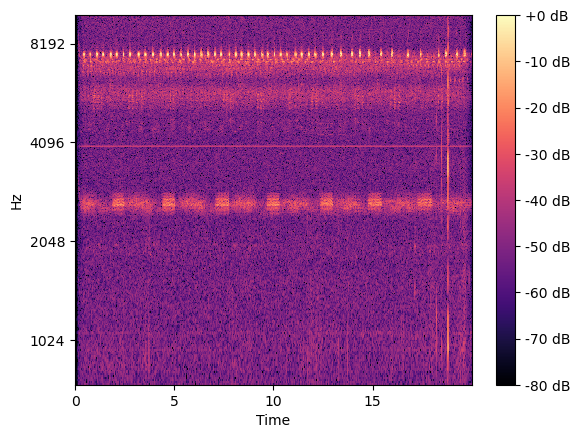

(213,)
(431,)
125


/var/folders/c7/3mttbbg11bl_11jhf9hbymzw0000gn/T/ipykernel_85870/1716666866.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  buckets[bucket_num] = buckets[bucket_num] + data[i]


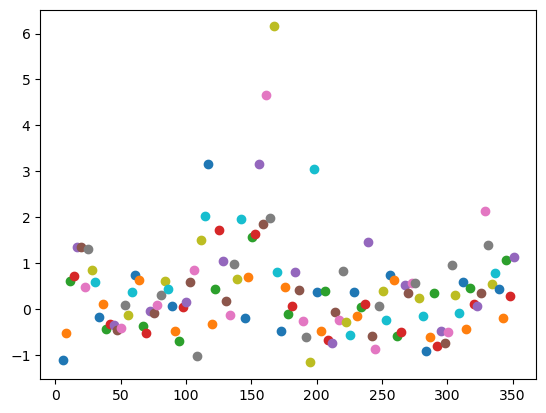

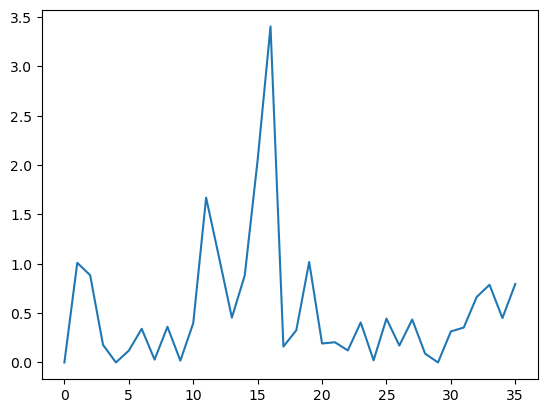

file name:  211254.0
critter : 11945    Gryllinae
Name: fam_or_subfam, dtype: object


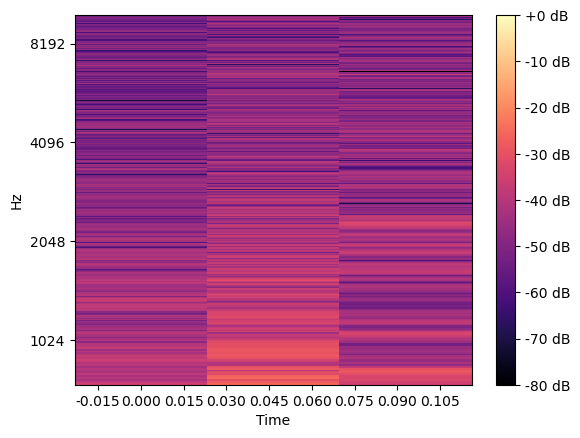

(0,)
(3,)


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by StandardScaler.

In [253]:
directory = '/Users/calvinyost-wolff/Documents/GitHub/chirpfiles/NoTalk'
hop_length = 1024
n_fft = 2048

graph_fft(directory)

In [254]:
def buckets(data, time):
    #sum square of deviations. Don't sum negative numbers. Average over a bucket
    buckets = np.zeros((36))
    #bucket i is 10i to 10i+9 chirps per minute
    counter = np.zeros((36))
    mini = min(data.shape[0],int(3*time/10 -3))
    for i in range(0,mini):
        bucket_num = int((i+2)/time*20*60/10)
        if data[i]>0:
            buckets[bucket_num] = buckets[bucket_num] + np.square(data[i])
        counter[bucket_num] = counter[bucket_num]+1
    print (i)
    for j in range(0,36):
        if buckets[j]>0:
            buckets[j] = buckets[j]/counter[j]
    return buckets

In [244]:
print(type(None) == None)

False
